In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import scipy.special
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import linregress

import sklearn
from sklearn.linear_model import LinearRegression

from yahooquery import Ticker

Simulate
$dr_t = \alpha dt + \beta dW_t$
for arbitrary $\alpha, \beta$

In [232]:
alpha = 0.01
beta = 0.5
r0 = 2.5
T = 1000
np.random.seed(1)
xis = np.random.normal(loc=0, scale=1, size=T)

simulation = [r0 + 1 * alpha + xis[0] * beta]
for j in range(1, T):
    simulation.append(simulation[j-1] + 1 * alpha + xis[j] * beta)

Text(0.5, 1.0, 'Simulation of arbitrary $dr_t = \\alpha dt + \\beta dW_t$')

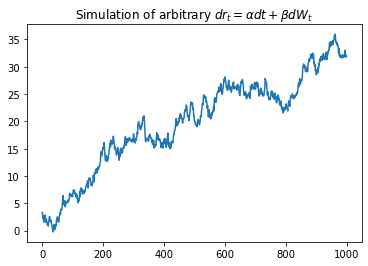

In [233]:
plt.plot(simulation)
plt.title(r"Simulation of arbitrary $dr_t = \alpha dt + \beta dW_t$")
# plt.savefig('drt_arbitrary.png')

Simulate
$dr_t = (\alpha - \beta r_t) dt + \nu dW_t$
for arbitrary $\alpha, \beta, \nu$

In [246]:
alpha = 0.05
beta = 0.03
nu = 0.1
r0 = 2
T = 1000
np.random.seed(1)
xis = np.random.normal(loc=0, scale=1, size=T)

simulation = [(alpha - beta * r0) * 1 + xis[0] * nu]
for j in range(1, T):
    simulation.append(simulation[j-1] + (alpha - beta * simulation[j-1]) * 1 + xis[j] * nu)

Text(0.5, 1.0, 'Estimation of arbitrary $dr_t = (\\alpha - \\beta r_t)dt + \\nu dW_t$')

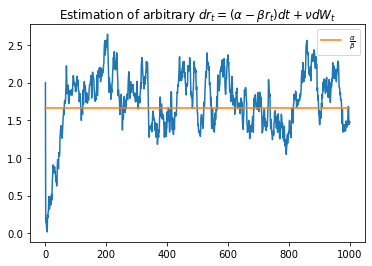

In [247]:
plt.plot([r0] + simulation)
plt.title(r"Simulation of arbitrary $dr_t = \alpha dt + \beta dW_t$")
plt.plot([alpha/beta]*T, label=r'$\frac{\alpha}{\beta}$')
plt.legend()
plt.title(r'Estimation of arbitrary $dr_t = (\alpha - \beta r_t)dt + \nu dW_t$')
# plt.savefig('drt_arbitrary_meanreversion.png')

Create Python Class that would model SDE of stock price
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$
using naive estimates for calibration:

$$\mu = \hat{\beta}_1, \quad \sigma = \sqrt{Var(S_t)}$$
where 
$$\hat{\beta}_1 = \hat{\beta}_1^{OLS}: \hat{S_t} = \hat{\beta}_0 + \hat{\beta}_1 t + u_t$$

In [236]:
class sde:
  def __init__(self, train_sample, n_paths, size):
    self.train_sample = train_sample
    self.n_paths = n_paths
    self.size = size


class stock(sde):
    def __init__(self, train_sample, n_paths, size):
        super().__init__(train_sample, n_paths, size)

    
    def _calibrate(self):
        mu = linregress(y=list(self.train_sample), x=np.linspace(0, len(self.train_sample), len(self.train_sample))).slope
        sigma = np.std(self.train_sample)

        return [mu, sigma]


    def simulate(self):
        parameters =  self._calibrate()
        forecast = []
        for i in range(0, self.n_paths):
            xis = np.random.normal(loc=0, scale=1, size=self.size)
            stocks_estimated = [self.train_sample[-1] + 1 * parameters[0] + xis[0] * parameters[1]]
            for j in range(1, self.size):
                stocks_estimated.append(stocks_estimated[j-1] + 1 * parameters[0] + xis[j] * parameters[1])
            forecast.append(stocks_estimated)
        
        return forecast

In [237]:
cola = Ticker('KO')
cola_data = cola.history(start='2019-02-19', end='2020-02-21', interval = '1d')
cola_data

close        low    volume       open       high  \
symbol date                                                               
KO     2019-02-19  44.830002  44.770000  25511300  45.320000  45.590000   
       2019-02-20  45.099998  44.799999  27464000  44.910000  45.240002   
       2019-02-21  45.860001  44.959999  23121200  45.000000  45.910000   
       2019-02-22  45.279999  45.200001  24728400  45.759998  45.950001   
       2019-02-25  44.939999  44.840000  23774400  45.439999  45.570000   
...                      ...        ...       ...        ...        ...   
       2020-02-13  59.610001  59.209999   8173200  59.380001  59.840000   
       2020-02-14  59.950001  59.619999   9965500  59.630001  60.070000   
       2020-02-18  59.529999  59.450001  10075700  59.810001  59.930000   
       2020-02-19  59.770000  59.470001   6265700  59.509998  60.000000   
       2020-02-20  59.720001  59.110001   7597200  59.680000  59.860001   

                    adjclose  dividends  
symbol date                              
KO     2019-02-19  38.656258        0.0  
       2019-02-20  38.889065        0.0  
       2019-02-21  39.544399        0.0  
       2019-02-22  39.044281        0.0  
       2019-02-25  38.751099        0.0  
...                      ...        ...  
       2020-02-13  53.029526        0.0  
       2020-02-14  53.331989        0.0  
       2020-02-18  52.958355        0.0  
       2020-02-19  53.171860        0.0  
       2020-02-20  53.127384        0.0  

[254 rows x 7 columns]

In [238]:
prices = cola_data['close']

In [239]:
break_ = 150

In [240]:
train = prices[:break_]
test = prices[break_:]

In [241]:
result = stock(train_sample=train, n_paths=100, size=len(test)).simulate()

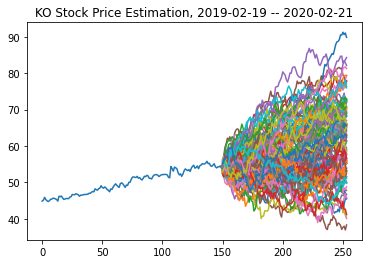

In [242]:
plt.plot(list(train))
for path in result:
    plt.plot([np.nan]*len(train) + list(path))

plt.title('KO Stock Price Estimation, 2019-02-19 -- 2020-02-21')
# plt.savefig('St_estimation.jpeg')